In [7]:
import math, random, pickle, os, copy, itertools, sys, gpytorch
import torch, logging, scipy.io
import numpy as np
import pandas as pd
from numpy import random
from datetime import datetime
import matplotlib.pyplot as plt
from collections.abc import Iterable

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)
sys.path.insert(1, os.path.join(PROJECT_DIR, 'utils'))

from experiments.data_sim import PVDataset
from utils.train_models import train_models
from utils.trained_svgd import serialize_model, TrainedSVGD
from utils.search_models import handle_search_space, find_best_model, best_lin_reg
from third_party.Synthetic_PV_Profiles.utils_pv import *

from meta_learn import GPRegressionLearned, GPRegressionMetaLearned, GPRegressionMetaLearnedSVGD

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)

exp_name = 'PV_UniModal'

# Load data
* vary the tilt of the installation and the azimuthal orientation
* same coordinates and altitude of central Lausanne

In [8]:
# ----- SET UP LOGGER -----
now = datetime.now().strftime("%m_%d_%H")
filename_env  = os.getcwd() + "/../PV/saved_results/" + exp_name + "_env"
filename_save = os.getcwd() + "/../PV/saved_results/" + exp_name + "_models"

# ------ LOAD DATA ------
# NOTE: env generated in notebook 1_visualization
file = open(filename_env, 'rb')
env_dict = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])
print(msg)
file.close()
num_clients = env_dict['num_clients'] 
num_features = len(env_dict['feature_names'])
print('\n'+env_dict['info'])

# ----- SELECT A SUBSET OF CLIENTS -----
#clients_subset = np.sort(random_state.choice(np.arange(num_clients), 
#                                     size=5, replace=False))
clients_subset= [12, 14, 15, 17, 22]
print('Subset of clients for demonstration: ', clients_subset)

[INFO] loaded data for 24 clients

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.6, different module_name, different inverter_name, 
Subset of clients for demonstration:  [12, 14, 15, 17, 22]


In [9]:
normalize_data = True
load_saved_models = True
feature_dim = 2
methods =['linreg', 'lingp', 'nn4', 'nn16', 'resgp'] # list of methods to run. subset of ['lin_reg', 'nn', 'gp', 'fedavg', 'ours'] 
methods_to_run = ['linreg', 'lingp']
verbose=True


# Step 1: Mean Model
### 1.1 fitting the model
Ridge regression applied for regularizing linear models. Linear GP trained using our method but on the data of only one client. Equivalent to training a GP for each client, with hyper-params maximizing marg log lik for this client plus regularization to the hyper-prior.
* Effect of data size reduction
* Need regularization?
* Sanity check: linear model vs. GP(linear, zero)

In [10]:
save_models = True
verbose=False
criterion = 'rsmse'

# -------- Define a fixed hyper-prior --------
hyper_prior_dict = {'lengthscale_raw_loc': 5,'lengthscale_raw_scale': 2.5, 
                    'noise_raw_loc': 10, 'noise_raw_scale': 5}

# set properties that are different based on the GP mean
options_base={
        # noise setup
        'optimize_noise':True, 'noise_std':None,  
        # linear model
        'covar_module_str': ['zero'], 'mean_module_str':['linear'],
        'kernel_nn_layers': [], 'mean_nn_layers':[],
        'nonlinearity_output': None, 'nonlinearity_hidden': None,
        'feature_dim':None, 
        # Configuration for GP-Prior learning
        'lr': 1e-2,           # learning rate for Adam optimizer'
        'lr_decay': 0.90,     # 'multiplicative learning rate decay factor applied after every 1000 steps'
        'task_batch_size': 5, # 'batch size for meta training, i.e. number of tasks for computing grads'
        'normalize_data': normalize_data,
        # Configuration for SVGD
        'num_iter_fit': 2000,
        'max_iter_fit': 3000,
        'early_stopping': True,
        'num_particles': [1],
        'bandwidth': 1,
        'n_threads': 8,
        'hyper_prior_dict': hyper_prior_dict,
        # loss parameters
        'reg_discount': 20
}

options = {
           'lingp': copy.deepcopy(options_base),
           'nn4': copy.deepcopy(options_base),
           'nn16': copy.deepcopy(options_base)
        }
options['nn4'].update({
                'covar_module_str': ['zero'], 'mean_module_str':['NN'],
                'kernel_nn_layers': [], 'mean_nn_layers':[(4,4)],
                'nonlinearity_output': None, 'nonlinearity_hidden': [torch.relu, torch.tanh],
                'feature_dim':None, 
                'num_iter_fit': 4000,
                'max_iter_fit': 6000})
options['nn16'].update({
                'covar_module_str': ['zero'], 'mean_module_str':['NN'],
                'kernel_nn_layers': [], 'mean_nn_layers':[(16,16)],
                'nonlinearity_output': None, 'nonlinearity_hidden': [torch.relu, torch.tanh],
                'feature_dim':None, 
                'num_iter_fit': 4000,
                'max_iter_fit': 6000})

# ---------- TRAIN ----------
for method_to_run in methods_to_run:
        if not method_to_run.startswith('resgp'):
                train_models(exp_name=exp_name, method_to_run=method_to_run,
                                env_dict=env_dict, random_seed=random_seed, criterion=criterion,
                                options=options, save_models=True, normalize_data=normalize_data,
                                verbose=verbose, clients_subset=clients_subset, reg_discount=20)

In [11]:
# ----- LOAD TRAINED MODELS -----
models_all = dict.fromkeys(methods)
results_all = dict.fromkeys(methods)

for method in methods:
    # init
    models_all[method] = dict.fromkeys(env_dict['train_scenarios'].keys())
    for scenario_name in env_dict['train_scenarios'].keys():
        models_all[method][scenario_name] = [None]*num_clients
    # load saved info
    if method.startswith('resgp'):
        continue
    print(method)
    file = open(filename_save + '_' + method, 'rb')
    res = pickle.load(file)
    file.close()
    # get results
    results_all[method] = res['results']
    # get models
    if method in ['linreg']:
        continue
    models_all[method] = res['models']
    # reconstruct models
    for scenario_name in env_dict['train_scenarios'].keys():
        if (method.startswith('nn')) and (scenario_name in ['1y', '5y']):
            continue
        for client_num in clients_subset:
            models_all[method][scenario_name][client_num] = TrainedSVGD(
                                        models_all[method][scenario_name][client_num])


linreg
lingp
nn4
nn16


## Step 2: Modelling Residuals

In [13]:
# form clients residulas data
method_base = 'nn4'
for scenario_name in env_dict['train_scenarios']:
    if scenario_name in ['1y', '5y']:
        continue
    env_dict['train_scenarios'][scenario_name]['clients_residuals'] = copy.deepcopy(env_dict['train_scenarios'][scenario_name]['clients_data'])
    for client_num in clients_subset:
        x_train, y_train, x_valid, y_valid = env_dict['train_scenarios'][scenario_name]['clients_residuals'][client_num]
        # model 
        model = models_all[method_base][scenario_name][client_num]
        # residual of train
        y_train_pred = model.predict(x_train, y_train, x_train)[0].reshape(y_train.shape)
        y_valid_pred = model.predict(x_train, y_train, x_valid)[0].reshape(y_valid.shape)
        env_dict['train_scenarios'][scenario_name]['clients_residuals'][client_num] = (
                                                                            x_train, 
                                                                            y_train-y_train_pred,
                                                                            x_valid,
                                                                            y_valid-y_valid_pred)

# --- OPTIONS ---
save_models = True
hyper_prior_dict_res = copy.deepcopy(hyper_prior_dict)
hyper_prior_dict_res.update({
    'constant_mean_loc':0, 'constant_mean_scale':1
                            })
options['resgp'] = copy.deepcopy(options_base)
options['resgp'].update({
                'covar_module_str': ['NN'], 'mean_module_str':['constant'],
                'kernel_nn_layers': [(4,4)], 'mean_nn_layers':[],
                'nonlinearity_output': torch.tanh, 'nonlinearity_hidden': torch.tanh, #[torch.relu, torch.tanh],#TODO
                'feature_dim':feature_dim, 
                'num_iter_fit': 2000,
                'max_iter_fit': 4000,
                'hyper_prior_dict':hyper_prior_dict_res,
                'reg_discount':10
                })


# ---------- TRAIN ----------

if 'resgp' in methods_to_run:
    train_models(exp_name=exp_name+'_'+method_base+'base', method_to_run='resgp', train_scenarios = 'sml', 
                env_dict=env_dict, random_seed=random_seed, criterion=criterion,
                options=options, save_models=True, normalize_data=normalize_data,
                verbose=verbose, clients_subset=clients_subset, reg_discount=1)

# ---------- LOAD ----------
else:
    for method in methods:
        if method.startswith('resgp'):
            print(method)
            # load saved info
            file = open(filename_save + '_' + method, 'rb')
            res = pickle.load(file)
            file.close()
            # get results
            results_all[method] = res['results']
            # get models
            models_all[method] = res['models']
            # reconstruct models
            for scenario_name in env_dict['train_scenarios'].keys():
                if (method.startswith('nn')) and (scenario_name in ['1y', '5y']):
                    continue
                for client_num in clients_subset:
                    models_all[method][scenario_name][client_num] = TrainedSVGD(
                                                models_all[method][scenario_name][client_num])

[INFO] finding the best model according to rsmse criterion.
[WARNING] input argument init_paramsnot used.

General model setup:
optimize_noise: True, noise_std: None, covar_module_str: NN, mean_module_str: constant, kernel_nn_layers: (4, 4), mean_nn_layers: [], nonlinearity_output: <built-in method tanh of type object at 0x7fc3fbeb3a00>, nonlinearity_hidden: <built-in method tanh of type object at 0x7fc3fbeb3a00>, feature_dim: 2, lr: 0.01, lr_decay: 0.9, task_batch_size: 5, normalize_data: True, num_iter_fit: 2000, max_iter_fit: 4000, early_stopping: True, num_particles: 1, bandwidth: 1, n_threads: 8, hyper_prior_dict: {'lengthscale_raw_loc': 5, 'lengthscale_raw_scale': 2.5, 'noise_raw_loc': 10, 'noise_raw_scale': 5, 'constant_mean_loc': 0, 'constant_mean_scale': 1}, 


[INFO]prior_factor: 0.020000999999999998, 
Iter 1/2000 - Time 0.01 sec - norm of gradients: 0.271 - Valid-LL: -3.555 - Valid-RMSE: 7.015 - Valid-Calibration 0.125
Iter 500/2000 - Time 3.23 sec -  average norm of gradien

KeyboardInterrupt: 

KeyError: ('a', 'c')

# Step 3: Analysis

In [ ]:
# print average over all clients      
for scenario_name in env_dict['train_scenarios']:  
    print('\nTrain scenario: '+scenario_name)
    for method in methods:
        if method.startswith('nn') and scenario_name in ['1y', '5y']:
            continue
        criterion_all_method = np.array([results_all[method][scenario_name][client_num]['valid_'+criterion] for client_num in clients_subset])
        msg = method + ' mean validation RMSE: {:2.2f} +/- {:.2f}'.format(
                    np.mean(criterion_all_method),
                    1.96*np.std(criterion_all_method))
        print(msg)



Train scenario: sml
linreg mean validation RMSE: 0.61 +/- 0.12
lingp mean validation RMSE: 0.63 +/- 0.04
nn4 mean validation RMSE: 0.64 +/- 0.05
nn16 mean validation RMSE: 0.63 +/- 0.04

Train scenario: 1y
linreg mean validation RMSE: 0.53 +/- 0.04
lingp mean validation RMSE: 0.55 +/- 0.04

Train scenario: 5y
linreg mean validation RMSE: 0.52 +/- 0.05
lingp mean validation RMSE: 0.54 +/- 0.04

Train scenario: 15y
linreg mean validation RMSE: 0.53 +/- 0.05
lingp mean validation RMSE: 0.54 +/- 0.04
nn4 mean validation RMSE: 0.45 +/- 0.03
nn16 mean validation RMSE: 0.45 +/- 0.04


In [ ]:
# ------ ANALYSIS ------
#print(res_linreg['sml'][clients_subset[0]].keys())

for method in methods:
    if method=='linreg':
        continue
    print('\nmodel: ' + method)
    res = results_all[method]
    for scenario_name in env_dict['train_scenarios'].keys():
        if method.startswith('nn') and scenario_name in ['1y', '5y']:
            continue
        print(scenario_name)
        clients_data = env_dict['train_scenarios'][scenario_name]['clients_data']
        num_pf_min=0
        num_pf_max=0
        for client_num in clients_subset:
            #print('\nclinet {:2.0f}'.format(client_num))
            beta = clients_data[client_num][0].shape[0]
            prior_factors=np.append(0,
                                    np.logspace(
                                        np.log10(1/options[method]['reg_discount']/beta+1e-6),
                                        np.log10(1/options[method]['reg_discount']*(1+1/1/beta-1e-6)),
                                        6)
                                    )
            opt_pf = res[scenario_name][client_num]['setup']
            if method.startswith('nn'):
                opt_pf = opt_pf[-1]
            if opt_pf == prior_factors[0] and prior_factors[0]>0:
                num_pf_min+= 1
            if opt_pf == prior_factors[-1]:
                num_pf_max+= 1
            #print('prior factors: ', np.logspace(np.log10(1/1/beta+1e-6), np.log10(1+1/1/beta-1e-6), 4))
            #print('optimal regularization for Ridge: ', res_linreg[scenario_name][client_num]['alpha'])
            #print('optimal prior factor for ours: ', res_lingp[scenario_name][client_num]['setup'])
        print('{:2.0f} clients with optimal PF in the interval, {:2.0f} with the smallest, {:2.0f} with the largest'.format(
            len(clients_subset)-num_pf_max-num_pf_min, num_pf_min, num_pf_max
        ))


model: lingp
sml
 5 clients with optimal PF in the interval,  0 with the smallest,  0 with the largest
1y
 5 clients with optimal PF in the interval,  0 with the smallest,  0 with the largest
5y
 5 clients with optimal PF in the interval,  0 with the smallest,  0 with the largest
15y
 5 clients with optimal PF in the interval,  0 with the smallest,  0 with the largest

model: nn4
sml
 5 clients with optimal PF in the interval,  0 with the smallest,  0 with the largest
15y
 5 clients with optimal PF in the interval,  0 with the smallest,  0 with the largest

model: nn16
sml
 5 clients with optimal PF in the interval,  0 with the smallest,  0 with the largest
15y
 5 clients with optimal PF in the interval,  0 with the smallest,  0 with the largest


### 1.2 Box plot of errors


Text(0.5, 1.0, 'Effect of Sample Size on Individually-Trained Models')

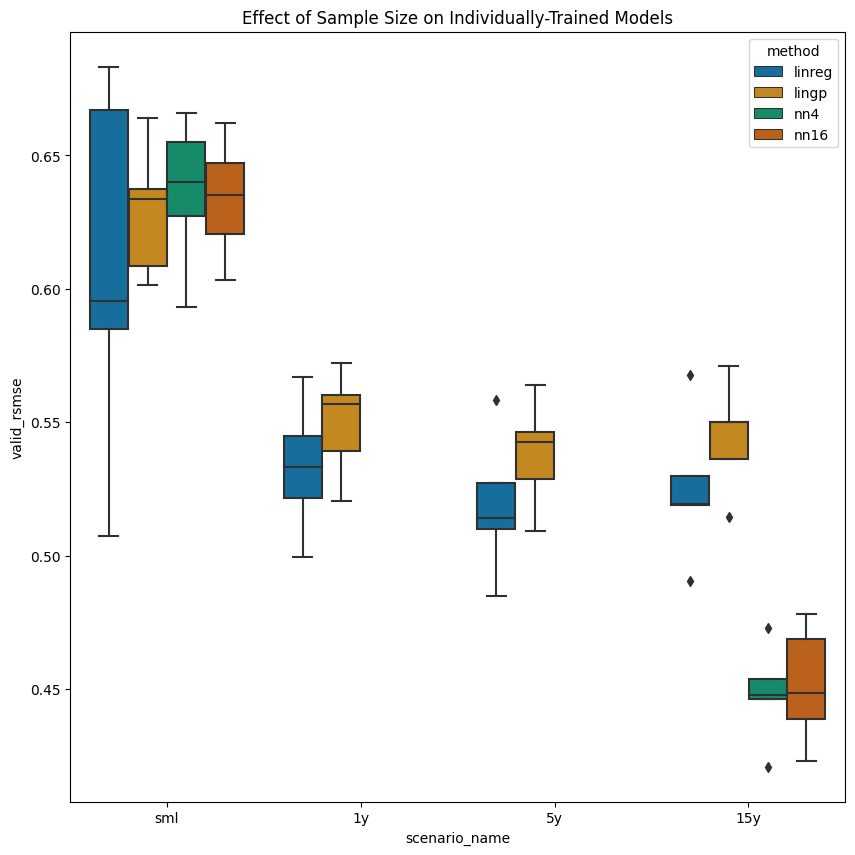

In [ ]:
criterion = 'rsmse'

num_rows = len(clients_subset) * len(env_dict['train_scenarios']) * len(methods)

res_df = {'client_num': np.zeros(num_rows), 'scenario_name': [None]*num_rows, 
          'valid_'+criterion: np.zeros(num_rows), 'method':[None]*num_rows}
n=0
for method in methods:
    for scenario_name in env_dict['train_scenarios']:
        if method.startswith('nn') and scenario_name in ['1y', '5y']:
            continue
        for client_num in clients_subset:
            res_df['client_num'][n] = client_num
            res_df['scenario_name'][n] = scenario_name
            res_df['method'][n] = method
            res_df['valid_'+criterion][n] = results_all[method][scenario_name][client_num]['valid_'+criterion]
            n +=1

#assert n==num_rows

res_df = pd.DataFrame(data=res_df)

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y='valid_'+criterion, x='scenario_name', 
            data=res_df, 
            palette="colorblind",
            hue='method', ax=ax)
ax.set_title('Effect of Sample Size on Individually-Trained Models')


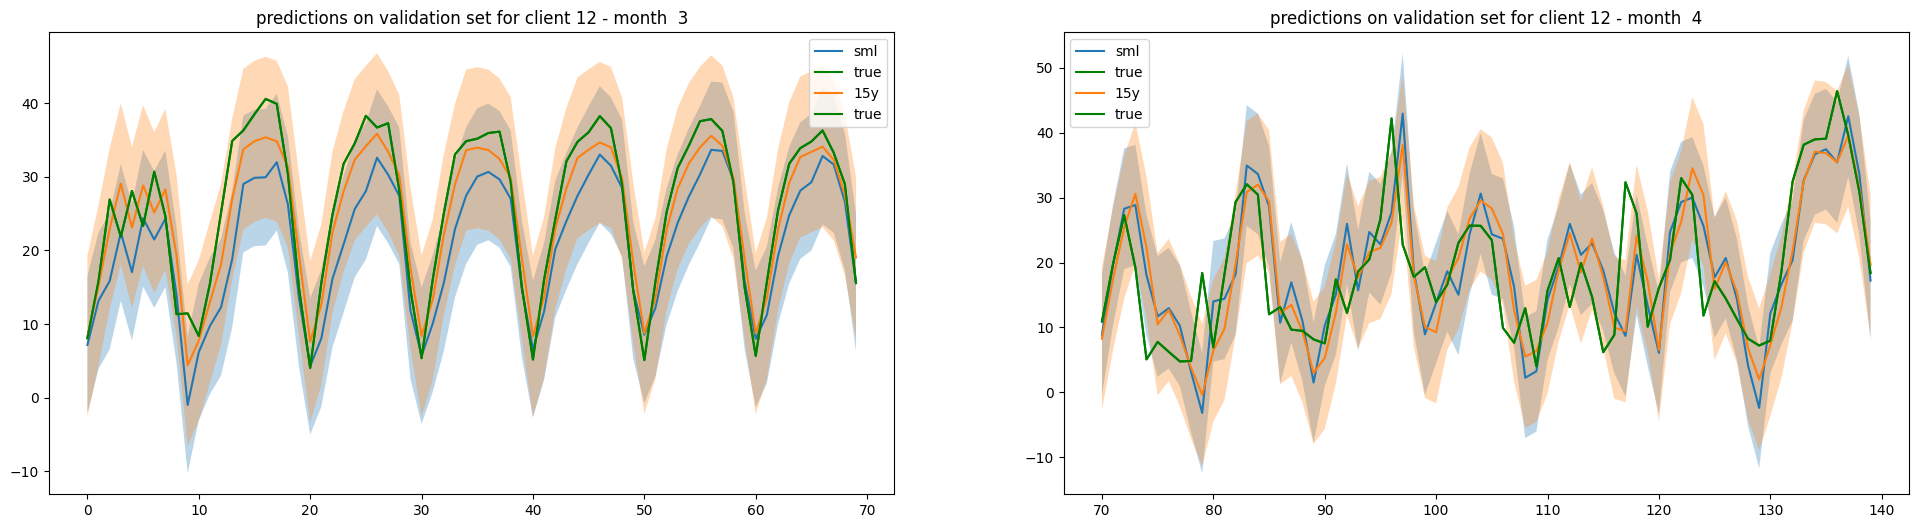

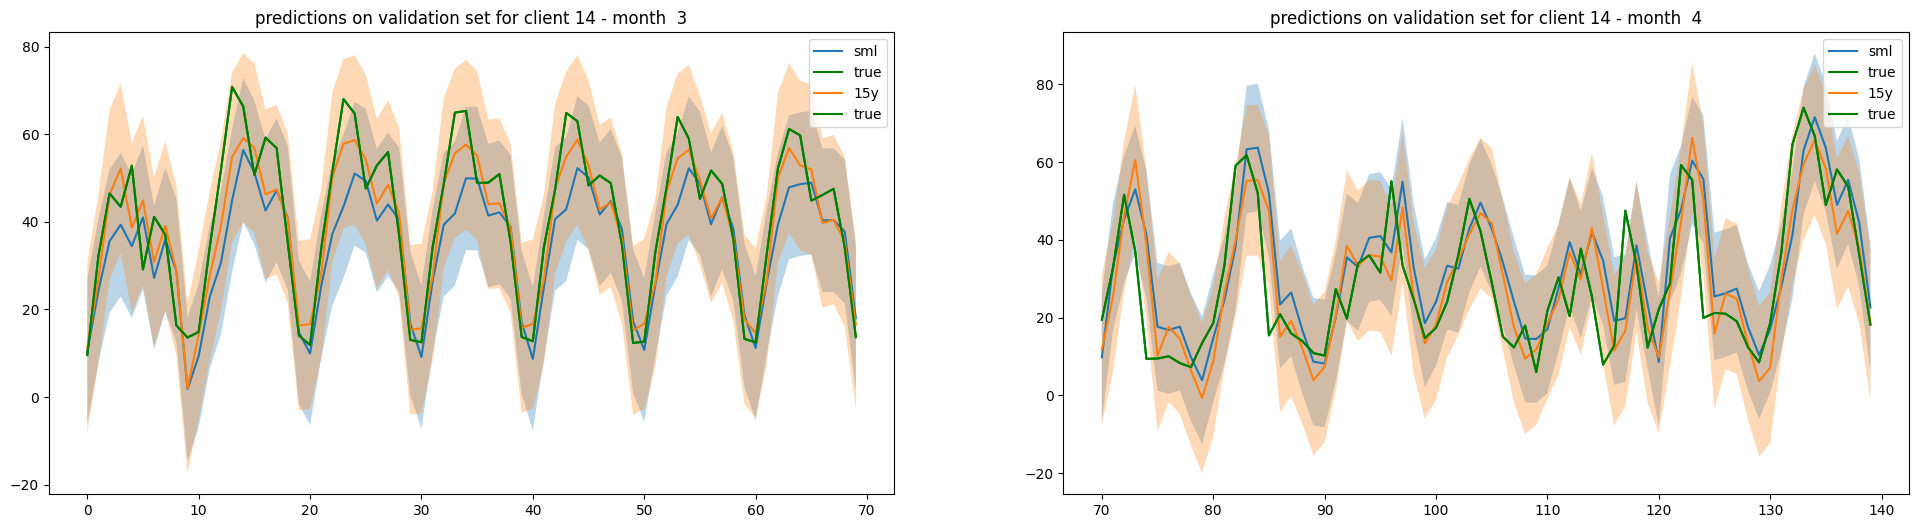

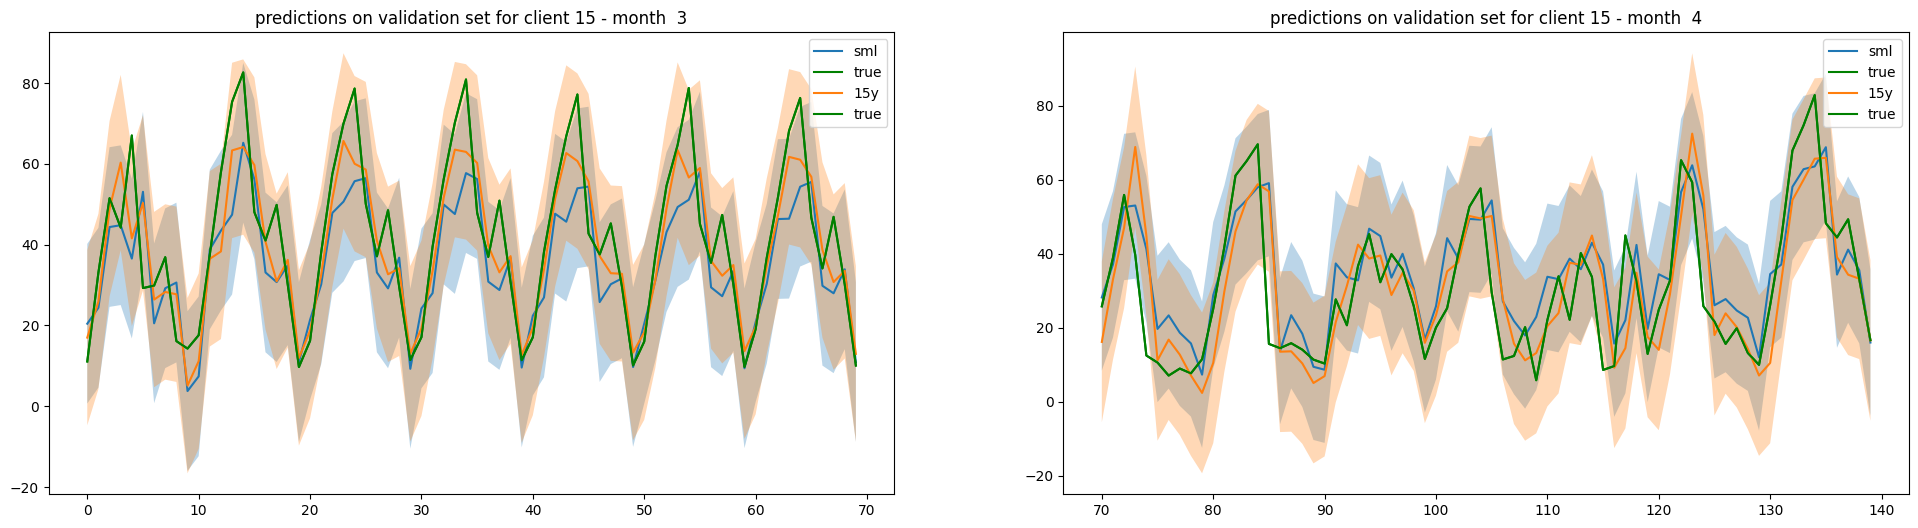

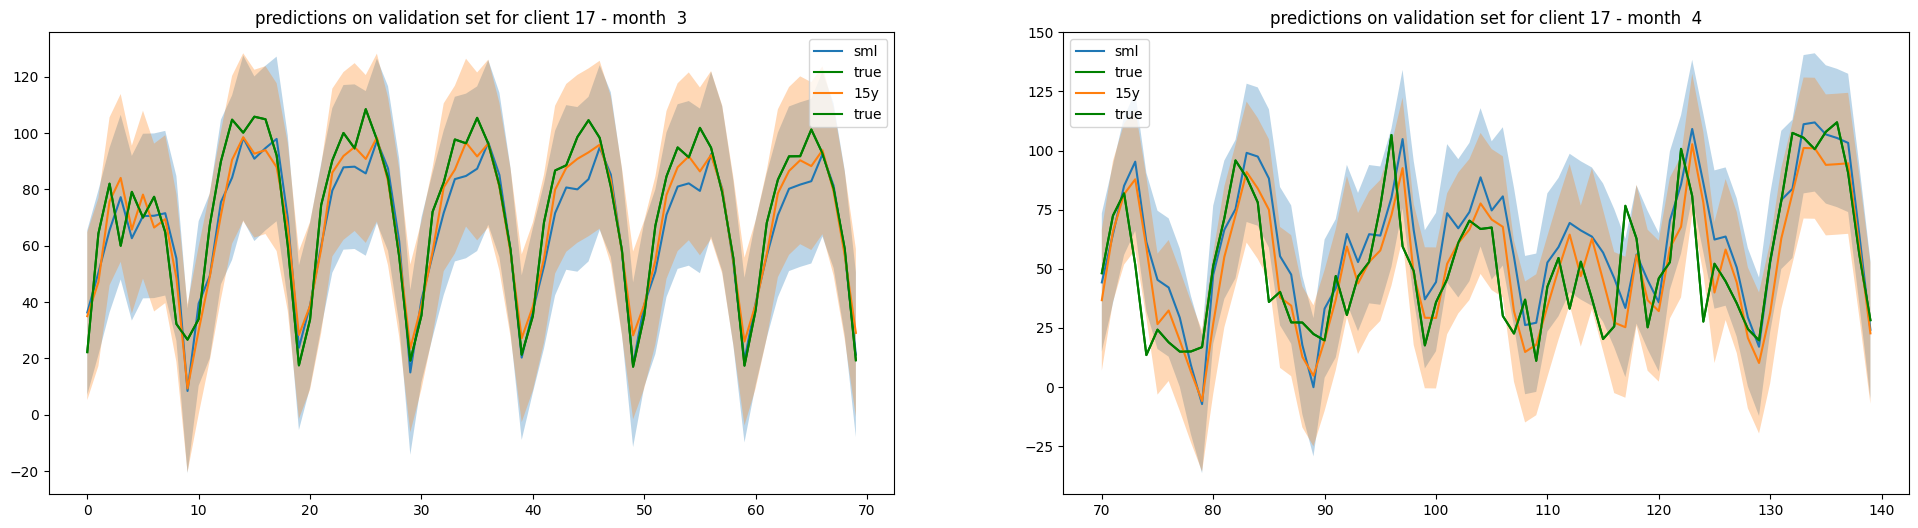

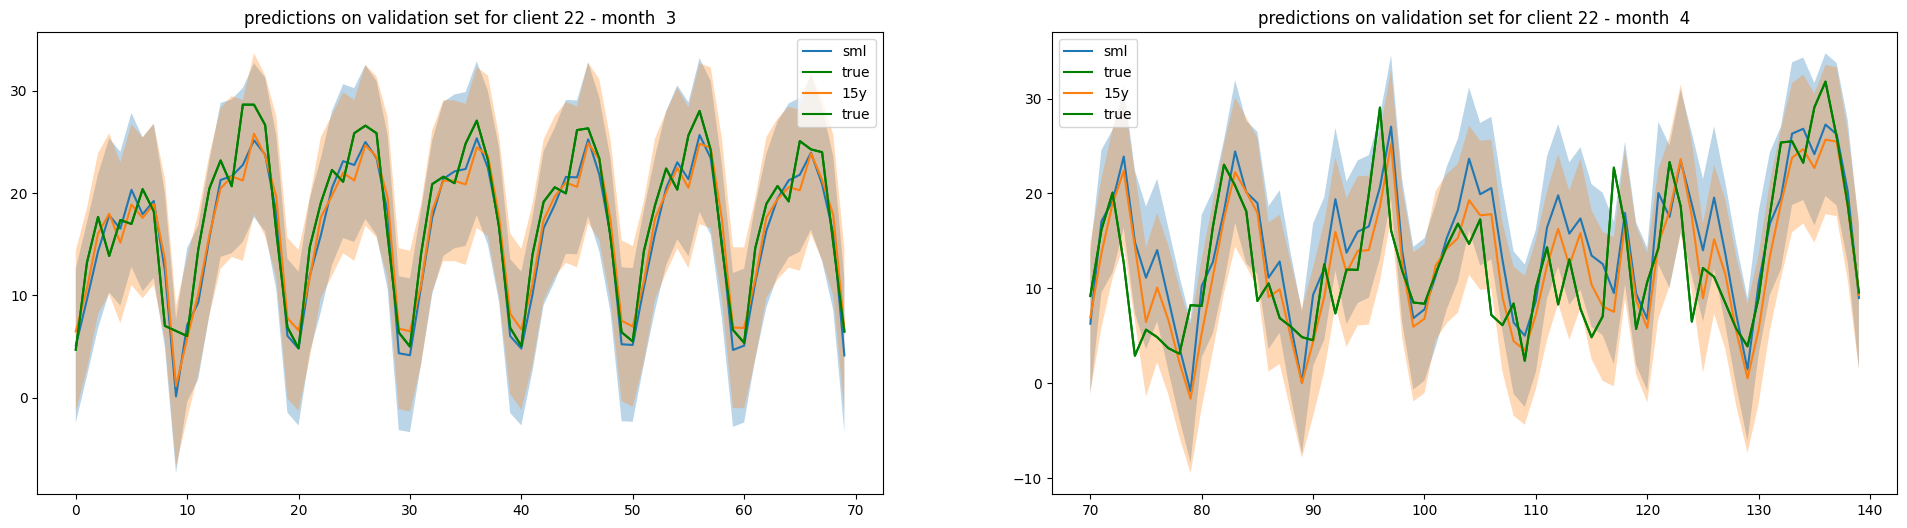

In [ ]:
'''
visulaize predictions for one client
'''                         
num_days = 7
method = 'lingp'
plot_mode = 'valid'
for client_num in clients_subset:
    fig, axs = plt.subplots(1,2,figsize=(24,6))
    for scenario_name in ['sml', '15y']: 
        time_series = env_dict['train_scenarios'][scenario_name]['time_series']
        model = models_all[method][scenario_name][client_num]
        x_train, y_train, x_valid, y_valid = env_dict['train_scenarios'][scenario_name]['clients_data'][client_num]
        if plot_mode=='valid':
            pred_mean, pred_std = model.predict(x_train, y_train, x_valid)
            y_true = y_valid
        elif plot_mode=='train':
            pred_mean, pred_std = model.predict(x_train, y_train, x_train)
            y_true=y_train
        for month_ind, month in enumerate(env_dict['months']):

            inds = np.arange(month_ind*7*len(env_dict['hours']), (month_ind+1)*7*len(env_dict['hours']))
            axs[month_ind].plot(inds, pred_mean[inds], 
                                label=scenario_name)
            axs[month_ind].fill_between(inds, pred_mean[inds]-1.96*pred_std[inds],pred_mean[inds]+1.96*pred_std[inds], alpha=0.3)
            axs[month_ind].plot(inds,y_true[inds], 'g', label='true')
            axs[month_ind].set_title('predictions on validation set for client {:2.0f} - month {:2.0f}'.format(client_num, month))
            axs[month_ind].legend()

        #visualize_pv(client_ts=time_series[client_num], 
        #            pred_mean=pred_mean[0:num_days*len(env_dict['hours'])], pred_std=None,
        #            selected_months=env_dict['months'], hours = env_dict['hours'], figsize=(16, 6))
                    #


[INFO] finding the best model according to rsmse criterion.
[WARNING] input argument init_paramsnot used.

General model setup:
optimize_noise: True, noise_std: None, covar_module_str: NN, mean_module_str: constant, kernel_nn_layers: (4, 4), mean_nn_layers: [], nonlinearity_output: <built-in method tanh of type object at 0x7fd4894bda00>, nonlinearity_hidden: <built-in method tanh of type object at 0x7fd4894bda00>, feature_dim: 2, lr: 0.01, lr_decay: 0.9, task_batch_size: 5, normalize_data: True, num_iter_fit: 4000, max_iter_fit: 6000, early_stopping: True, num_particles: 1, bandwidth: 1, n_threads: 8, hyper_prior_dict: {'lengthscale_raw_loc': 5, 'lengthscale_raw_scale': 2.5, 'noise_raw_loc': 10, 'noise_raw_scale': 5, 'constant_mean_loc': 0, 'constant_mean_scale': 1}, 


[INFO]prior_factor: 0.0010010000000000004, 
Iter 1/4000 - Time 0.01 sec - norm of gradients: 0.042 - Valid-LL: -3.584 - Valid-RMSE: 7.281 - Valid-Calibration 0.128
Iter 500/4000 - Time 3.18 sec -  average norm of gradie

KeyboardInterrupt: 

In [ ]:
print(options.keys())
options['res_gp'] = copy.deepcopy(options_base)
print(options['res_gp'])
options['res_gp'].update({
                'covar_module_str': ['NN'], 'mean_module_str':['constant'],
                'kernel_nn_layers': [(4,4)], 'mean_nn_layers':[],
                'nonlinearity_output': torch.tanh, 'nonlinearity_hidden': torch.tanh, #[torch.relu, torch.tanh],#TODO
                'feature_dim':feature_dim, 
                'num_iter_fit': 4000,
                'max_iter_fit': 6000})
print(options['res_gp'])

dict_keys(['lingp', 'nn4', 'res_gp'])
{'optimize_noise': True, 'noise_std': None, 'covar_module_str': ['zero'], 'mean_module_str': ['linear'], 'kernel_nn_layers': [], 'mean_nn_layers': [], 'nonlinearity_output': None, 'nonlinearity_hidden': None, 'feature_dim': None, 'lr': 0.01, 'lr_decay': 0.9, 'task_batch_size': 5, 'normalize_data': True, 'num_iter_fit': 2000, 'max_iter_fit': 3000, 'early_stopping': True, 'num_particles': [1], 'bandwidth': 1, 'n_threads': 8, 'hyper_prior_dict': {'lengthscale_raw_loc': 5, 'lengthscale_raw_scale': 2.5, 'noise_raw_loc': 10, 'noise_raw_scale': 5}, 'prior_factor': None}
{'optimize_noise': True, 'noise_std': None, 'covar_module_str': ['NN'], 'mean_module_str': ['constant'], 'kernel_nn_layers': [(4, 4)], 'mean_nn_layers': [], 'nonlinearity_output': <built-in method tanh of type object at 0x7fd4894bda00>, 'nonlinearity_hidden': <built-in method tanh of type object at 0x7fd4894bda00>, 'feature_dim': 2, 'lr': 0.01, 'lr_decay': 0.9, 'task_batch_size': 5, 'norma